# <center> Sentiment and offensive language analysis - Group 10 - Project 4

Through this report we are aiming to detect offensiveness and sentimentality of different tweets

# Export packages

In [1]:
import nltk
import re
import difflib
from nltk import agreement
from nltk.tokenize import TweetTokenizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random #only used for generating 100 random tweets for manual labelling
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV

from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPClassifier
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, classification_report, roc_auc_score, roc_curve, recall_score, precision_score, f1_score
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC
from sklearn.metrics import cohen_kappa_score


## All functions for the notebook

During the tokenaziation punctuations, emojois, pointless strings and characters are removed

In [2]:
def tokenizer(tweets):
    """
    Function that takes a list of strings and returns the tokenized version of each string
    """
    #counter = 0
    #token_pat = re.compile(r'[\w@’#]+')
    token_pat = re.compile(r'\w+')
    skippable_pat = re.compile(r'[\s\d]+|@user')

    non_white_space = re.compile(r'[^@’#\w\s]') #Finds characters that are not white_space nor word characters (nor @’#)
    #print("these are the tweets")
    #print(tweets)
    
    # Initialise lists
    tokens = []
    unmatchable = []

# Compile patterns for speedup
    token_pat = re.compile(r'\w+')

    tokenlist = []
    for i in tweets:
        #counter = counter + 1
        #print(counter)
        #tokens = []
        #unmatchable = []
        line = i.lower()
        #print("this is i: ",i)
        
        while line:
            #print("this is the line")
            #print(line)
            skippable_match = re.search(skippable_pat, line)
            if skippable_match and skippable_match.start() == 0:
                line = line[skippable_match.end():]
            else:
                token_match = re.search(token_pat, line)
                #print("tokens_match")
                #print(token_match)
                #print(token_match.start())
                if token_match and token_match.start() == 0:
                    #print("\nAPPEND IS RUNNING\n")
                    #print(line[:token_match.end()])
                    tokens.append(line[:token_match.end()])
                    line = line[token_match.end():]
                else:
                    unmatchable_end = len(line)
                    if skippable_match:
                        unmatchable_end = skippable_match.start()
                    if token_match:
                        unmatchable_end = min(unmatchable_end, token_match.start())
                    unmatchable.append(line[:unmatchable_end])
                    line = line[unmatchable_end:]
        tokenlist.append(tokens)
        tokens = []
    return(tokenlist)


def compare_tokenizers(bool):
    if bool==True:
        tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
        j = 0
        for i in training_data: 
            temp = i
            diff = difflib.context_diff(tknzr.tokenize(i),token_tweets[j])
            #print("".join(diff), end = "")
            print(i,"tknzr:",tknzr.tokenize(i),"\ntokenlist:",token_tweets[j],"\n")
            j+=1

            
def import_(classification_task, file_name):
    with open("../data/raw/"+classification_task+"/"+file_name, "r", encoding="utf-8") as f:
        temp = [int(line.strip("\n")) for line in f]
    return(temp)


def import_and_tokenize(classification_task, file_name):
    with open("../data/raw/"+classification_task+"/"+file_name, "r", encoding="utf-8") as f:
        temp = [line for line in f]
    return(tokenizer(temp))


def report_clf_stats(predicted, test, classification_task):
    name_dict = {"offensive": ["Not offensive","Offensive"], "sentiment": ["Negative", "Neutral", "Positive"]}
    print(metrics.accuracy_score(test, predicted))
    print(metrics.classification_report(predicted, test, target_names=name_dict[classification_task]),"\n")
    print(metrics.confusion_matrix(test, predicted))

## Reading data
### The Offensive Training Data

In [13]:
f = open("../data/raw/offensive/train_text.txt", 'r', encoding = "utf-8")
inputlist = [line for line in f]
f.close()

training_data, validation_data = inputlist[:len(inputlist)//2], inputlist[len(inputlist)//2:]

In [14]:
token_tweets = tokenizer(training_data)
print(token_tweets)
#print(token_tweets[1])
#[print(*i) for i in token_tweets]

[['bono', 'who', 'cares', 'soon', 'people', 'will', 'understand', 'that', 'they', 'gain', 'nothing', 'from', 'following', 'a', 'phony', 'celebrity', 'become', 'a', 'leader', 'of', 'your', 'people', 'instead', 'or', 'help', 'and', 'support', 'your', 'fellow', 'countrymen'], ['eight', 'years', 'the', 'republicans', 'denied', 'obama', 's', 'picks', 'breitbarters', 'outrage', 'is', 'as', 'phony', 'as', 'their', 'fake', 'president'], ['get', 'him', 'some', 'line', 'help', 'he', 'is', 'gonna', 'be', 'just', 'fine', 'as', 'the', 'game', 'went', 'on', 'you', 'could', 'see', 'him', 'progressing', 'more', 'with', 'his', 'reads', 'he', 'brought', 'what', 'has', 'been', 'missing', 'the', 'deep', 'ball', 'presence', 'now', 'he', 'just', 'needs', 'a', 'little', 'more', 'time'], ['she', 'is', 'great', 'hi', 'fiona'], ['she', 'has', 'become', 'a', 'parody', 'unto', 'herself', 'she', 'has', 'certainly', 'taken', 'some', 'heat', 'for', 'being', 'such', 'an', 'well', 'idiot', 'could', 'be', 'optic', 'too

###  Comparing our own tokenizer with TweetTokenizer from nltk library
<b>Set below value 'see_output' = True for comparison <i>(It'll run for a while)</i></b>


In [15]:
# Comparing our own tokenizer with TweetTokenizer from nltk library
# Set below value 'see_output' = True for comparison
see_output = False
compare_tokenizers(see_output)

### Corpus size of Offensive and sentiment training sets respectively:

In [16]:
%%bash
wc ../data/raw/offensive/train_text.txt
wc ../data/raw/sentiment/train_text.txt

  11916  262370 1540990 ../data/raw/offensive/train_text.txt
  45615  877516 5015644 ../data/raw/sentiment/train_text.txt


<b>Offensive:</b> 11916 lines/tweets, 262370 words <br>
<b>Sentiment:</b> 45615 lines/tweets, 877516 words

### Running tokenizer function on offensive and sentiment training data to get token count right

In [17]:
with open("../data/raw/offensive/train_text.txt", "r",  encoding = "utf-8",) as f:
    offensive_raw = [line for line in f]

with open("../data/raw/sentiment/train_text.txt", "r",  encoding = "utf-8",) as f:
    sentiment_raw = [line for line in f]


<i>Below cell line takes some time to run

In [18]:
offensive_tokens = tokenizer(offensive_raw)
sentiment_tokens = tokenizer(sentiment_raw)

## The top 10 most frequent words of each dataset

In [19]:
#from https://stackoverflow.com/questions/45019607/count-occurrence-of-a-list-in-a-list-of-lists
off_uniq = pd.Series(offensive_tokens).explode().value_counts()
sent_uniq = pd.Series(sentiment_tokens).explode().value_counts()

print("Offensive dataset, top 10 tokens:","\n",off_uniq[:10],"\n")
print("Sentiment dataset, top 10 tokens:","\n",sent_uniq[:10])

#Turning above pd.series into dataframes, for ease of use later
#Transformation found at:https://stackoverflow.com/questions/40224319/pandas-series-to-dataframe-using-series-indexes-as-columns
off_uniq = off_uniq.to_frame().reset_index()
sent_uniq = sent_uniq.to_frame().reset_index()

#Renaming columns in dataframes
off_uniq.columns = ["token","count"]
sent_uniq.columns = ["token","count"]

Offensive dataset, top 10 tokens: 
 the    8134
is     5859
to     5589
you    4920
a      4900
and    4604
of     3441
i      3360
are    3236
he     2778
dtype: int64 

Sentiment dataset, top 10 tokens: 
 the    38004
to     20952
i      16899
in     13714
on     13121
a      13028
and    12699
of     10897
for     9992
is      9706
dtype: int64


### type/token ratio

In [20]:
#Types == Amount of different Tokens in dataset
off_types = len(off_uniq["token"])
sent_types = len(sent_uniq["token"])
print("Offensive Types: {}\nSentiment types: {}\n".format(off_types,sent_types))

#Tokens == Amount of all "Words" in dataset
off_token_amount = off_uniq["count"].sum()
sent_token_amount = sent_uniq["count"].sum()
print("Offensive tokens, amount: {}\nSentiment tokens, amount: {}\n".format(off_token_amount, sent_token_amount))

#Type/token ratio (=ttratio)
off_ttratio = off_types/off_token_amount
sent_ttratio = sent_types/sent_token_amount
print("Offensive type/token ratio: {:.4f}\nSentiment type/token ratio: {:.4f}".format(off_ttratio, sent_ttratio))

Offensive Types: 17683
Sentiment types: 42056

Offensive tokens, amount: 235878
Sentiment tokens, amount: 871896

Offensive type/token ratio: 0.0750
Sentiment type/token ratio: 0.0482


#### Types that only occur 1, 2 or 3 times
<ul>
    <li>Things like Hashtags and misspelled nouns are prevalent, but they, more importantly, contain most of the Types in the vocabulary</li>
    <li>Tokens that occur only once make up ~ 50% of the types in both datasets!</li>
</ul>

In [21]:
print("Offensive types w. freq 1, 2, or 3 divided by total types: {:.2f}%".format(
    len(off_uniq.loc[(off_uniq["count"]==1) | (off_uniq["count"]==2) | (off_uniq["count"]==3)])/off_types*100))
print("Sentiment types w. freq 1, 2, or 3 divided by total types: {:.2f}%".format(
    len(sent_uniq.loc[(sent_uniq["count"]==1) | (sent_uniq["count"]==2) | (sent_uniq["count"]==3)])/sent_types*100))

print()

print("Offensive types w. freq. just 1 divided by total types: {:.2f}%".format(len(off_uniq.loc[off_uniq["count"]==1])/off_types*100))
print("Sentiment types w. freq. just 1 divided by total types: {:.2f}%".format(len(sent_uniq.loc[sent_uniq["count"]==1])/sent_types*100))

Offensive types w. freq 1, 2, or 3 divided by total types: 73.95%
Sentiment types w. freq 1, 2, or 3 divided by total types: 73.42%

Offensive types w. freq. just 1 divided by total types: 52.87%
Sentiment types w. freq. just 1 divided by total types: 55.01%


Amount of types showing up x times in the offensive dataset (e.g 14000 tokens only showing up once, and so on)<br>
The 500 types with the highest count are skipped, to make x-axis on the plot visible

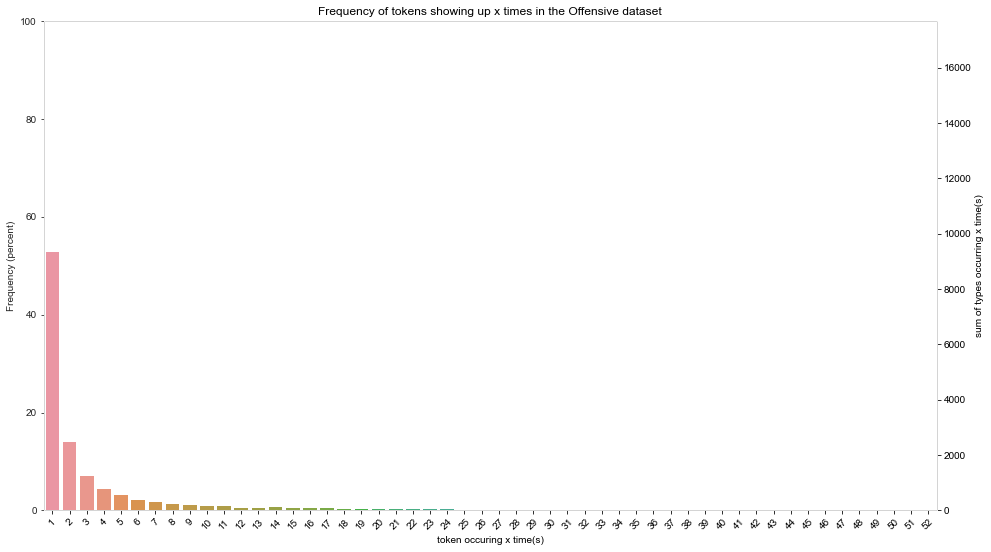

In [22]:
# Amount of types showing up x times in the offensive dataset (e.g 14000 tokens only showing up once, and so on)
# Skipping top 500 types, for visibility in plot (They're not impactful on the plot otherwise, the most frequent of 
#     these 500 entries is 13)
#Plotting visual and double y-axes found at https://stackoverflow.com/questions/33179122/seaborn-countplot-with-frequencies

fig, ax = plt.subplots(figsize=(16,9))
sns.countplot(x="count", data=off_uniq[500:]) #Sns counts the type frequency of each word, and plots it
sns.set_style("darkgrid")
plt.title("Frequency of tokens showing up x times in the Offensive dataset")
plt.xlabel("token occuring x time(s)")
plt.ylabel("sum of types occurring x time(s)")
ax.tick_params('x',rotation=45, labelsize = 10) #xlabels are rotated 45 degrees and made bigger

# Twin axes, creating and visualising
ax2 = ax.twinx()
ax2.set_ylabel("Frequency (percent)")

# Moving the ticks and labels of y-axes to opposite sides for more visually pleasing plot
ax2.yaxis.tick_left()
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

# Setting appropriate limits for the y-axes, removing duplicate grid
ax.set_ylim(0,len(off_uniq))
ax2.set_ylim(0,100)
ax2.grid(None)

### Noticable difference in the two datasets

<ul>
    <li>Big difference in size, sentiment dataset over twice the amount of tokens (=library of sentiment twice the size of library of offensive language)</li>
    <li>otherwise quite similar, in both sets the percentage of the vocabulary made up of tokens w. frq. 1 is ~ 50%</li>
    <ul><li>Both datasets also seem to follow Zipf's law (see below graphs)</li>
    </ul>
</ul>
    

### Corpus Statistics Consistent with Zipf's law?

Log-log plot of the rank of token frequency against against the frequency in the offensive dataset

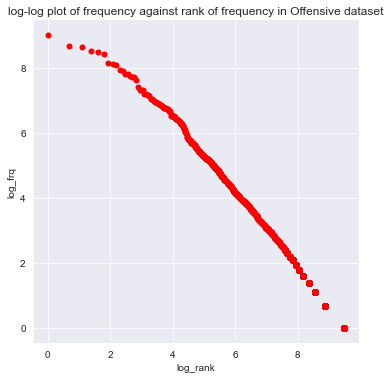

In [23]:
off_uniq["log_frq"] = np.log(off_uniq["count"])
off_uniq["log_rank"] = np.log(off_uniq["count"].rank(ascending=False))
sns.relplot(x="log_rank",y="log_frq", data=off_uniq, color="red", edgecolor=(0.2,0,0,0.01)).set(title=
                "log-log plot of frequency against rank of frequency in Offensive dataset")
plt.show()

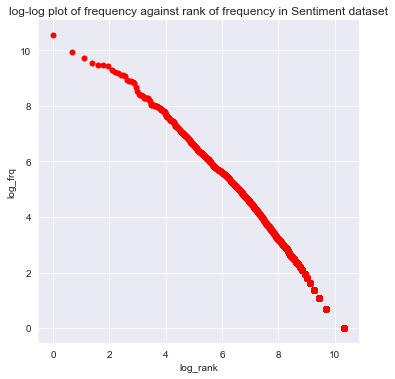

In [24]:
sent_uniq["log_frq"] = np.log(sent_uniq["count"])
sent_uniq["log_rank"] = np.log(sent_uniq["count"].rank(ascending=False))
sns.relplot(x="log_rank",y="log_frq", data=sent_uniq, color="r", edgecolor=(0.2,0,0,0.01)).set(title=
                "log-log plot of frequency against rank of frequency in Sentiment dataset")
plt.show()

<b>As seen in the above plots, both datasets seem consistent with Zipf's law</b>

## Task 3: Manual Annotation & Inter-user Agreement

### Generating 100 random tweets for manual annotation

In [25]:
random.seed(42) #Seeded for consistency
random_tweets = random.sample(list(enumerate(sentiment_raw)),100)
rtweet_index = [i[0] for i in random_tweets]

# #File-generation is commented out, as the randomness is seeded, thus Making the same "Random" file every time
# with open("../data/interim/random_tweets.txt","w", encoding="utf-8") as f:
#     [f.write(str(i[1])+"\n") for i in random_tweets]

In [26]:
sent_label = pd.read_csv('../data/raw/sentiment/train_labels.txt',header=None)
sent_raw = pd.read_csv("../data/raw/sentiment/train_text.txt",header=None, sep="\n",quoting=3)

### Putting the manually annotated labels into a single dataframe

In [27]:
man_labels = pd.read_csv("../data/interim/manual_annotation/all_combined.csv", delimiter=",") #All manual labels
man_labels = man_labels.iloc[:,:-1] #Not using the _A0_value column from the file
display(man_labels) #The manually annotated labels, put into a dataframe

same_label = man_labels.eq(man_labels.iloc[:,0], axis=0).all(1) #Finding where all annotators agree on a label
print("# of equal labels:",np.sum(same_label))
obs_agreement = np.sum(same_label)/len(man_labels.iloc[:,0])
print("observed agreement:",obs_agreement)

,anno_1,anno_2,anno_3,anno_4
0,1,1,1,1
1,2,1,1,1
2,2,2,2,2
3,0,0,0,0
4,0,1,2,2
...,...,...,...,...
95,0,2,2,0
96,0,2,2,2
97,1,1,2,1
98,1,1,1,1


# of equal labels: 34
observed agreement: 0.34


### Calculating Chance-corrected agreement

In [28]:
#Formatting manual label answers to calculate Scott's pi, Fleiss' kappa with nltk.agreement
tweets_len = len(man_labels.iloc[:,0])
formatted_answers = [] #Formatting of only the manually annotated data
for column in range(len(man_labels.columns)):
    for tweet_num in range(tweets_len):
        formatted_answers.append([column+1,tweet_num,man_labels.iloc[tweet_num,column]])

#adding the "True" labels to all_formatted:
all_formatted = formatted_answers.copy() #Formatting of BOTH the manually annotated data AND the "True" Annotation of the data
true_label_list = list(sent_label.iloc[rtweet_index][0])
for i in range(tweets_len):
    all_formatted.append([len(man_labels.columns)+1,i,true_label_list[i]])
    
print("lenght of formatted_answers:",len(formatted_answers))
print("length of all_formatted:",len(all_formatted)) #should be 100 characters longer than the above

lenght of formatted_answers: 400
length of all_formatted: 500


#### Chance-corrected for just the manual labels

The inter-annotator agreement values are almost 0.4, which can be decided as fair or moderate

In [29]:
"""
Note that in the nltk.agreement documentation: https://www.nltk.org/_modules/nltk/metrics/agreement.html
the returned value is the chance-corrected agreement, not just A_e.
"""
ratingtask = agreement.AnnotationTask(data=formatted_answers)
print("Scott's pi: {:.4f}\nCohen's kappa: {:.4f}\nFleiss' kappa: {:.4f}".format(ratingtask.pi(),ratingtask.kappa(),ratingtask.multi_kappa()))


Scott's pi: 0.3962
Cohen's kappa: 0.3950
Fleiss' kappa: 0.3968


#### Chance-corrected for both the manual labels AND the "true" labels

In [30]:
all_label_rating = agreement.AnnotationTask(data=all_formatted)
print("Scott's pi: {:.4f}\nCohen's kappa: {:.4f}\nFleiss' kappa: {:.4f}".format(all_label_rating.pi(),all_label_rating.kappa(),all_label_rating.multi_kappa()))


Scott's pi: 0.3911
Cohen's kappa: 0.3905
Fleiss' kappa: 0.3918


### Showing the tweets with agreeing/disagreeing manual labels for later discussion, saved to file

In [31]:
same_label[same_label==False]
manual_tweets = sent_raw.loc[rtweet_index]

#tweets labels disagree on
annotation_disagree = manual_tweets.iloc[np.where(same_label==False)]
display(annotation_disagree[:10])#Showing the 10 first tweets with disagreeing manual annotation

#tweets labels agree on
annotation_agree = manual_tweets.iloc[np.where(same_label==True)]

# File creation commented out
# annotation_disagree.to_csv("../data/interim/man_anno_disagree.txt", header=None, index=False)
# annotation_agree.to_csv("../data/interim/man_anno_agree.txt", header=None, index=False)

#man_labels[same_label==True]["anno_1"][:10]


,0
7296,Convenient location to the Georgia Dome: This ...
16049,In bed in Plymouth hotel for the last night of...
14628,Former Florida Gov. Jeb Bush said Thursday tha...
6717,Exciting weekend. Kitchen being fitted today F...
44348,Will the PM stand by and watch his colleagues ...
35741,@user take Niall's guitar and play on stage at...
5697,When you're sick of waiting for a book to come...
27651,"""12 Ways June Squibb Is the New Jennifer Lawre..."
2082,i want Michelle Obama to be president with Mic...
1952,@user @user As far as I know Rick Perry hasn't...


# Calculating the Observed Agreement result of the manual annotation

During the manual annotation we found in case:
- Only 34% of the cases we totally agreed 34% 
- 43% of the cases one of us had different opinion
- 23% of the cases (this means 0.5 Observed Agreement result) we couldn't decide obviously the sentiment of the sentence

Text(0.5, 1.0, 'Observed Agreement results of manual annotation')

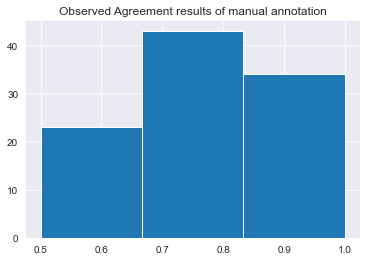

In [32]:
# hide errors
pd.options.mode.chained_assignment = None

man_labels.reset_index()
man_labels["AO"] = 1.1
for i in range(len(man_labels)):
    l = []
    rowData = man_labels.loc[ i , : ]
    l.append(rowData[0])
    l.append(rowData[1])
    l.append(rowData[2])
    l.append(rowData[3])
    occurence_count = Counter(l)
    same_counter = occurence_count.most_common(1)[0][1]
    res=occurence_count.most_common(1)[0][0]
    ao = same_counter/4
    #print(ao)
    man_labels["AO"][i] = ao
    #print("Variance of sample set is % s"  %(statistics.variance(l)),"AO number is : ", ao, "winner is :", res)
    None

plt.hist(man_labels["AO"], label='linear', bins=3)
plt.title('Observed Agreement results of manual annotation')

# Cohen's kappa score heatmap

In [38]:
man_and_true = man_labels.copy()
man_and_true = man_and_true.iloc[:,:4]
man_and_true["true"] = true_label_list

annotator_np = np.empty((5,5))

for i in range(len(man_and_true.columns)):
    for j in range(i, len(man_and_true.columns)):
        l1 = list(man_and_true.iloc[:,i])
        l2 = list(man_and_true.iloc[:,j])
        score = cohen_kappa_score(l1,l2)
        annotator_np[i,j] = score
        annotator_np[j,i] = score
#         if j==4:
#             print("Anno_{}, True:\n".format(i+1),score,"\n")
#         else:
#             print("Anno_{}, Anno_{}:\n".format(i+1,j+1),score,"\n")

#print(annotator_np)


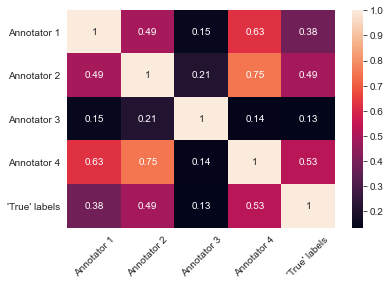

In [39]:
fig, ax = plt.subplots()

sns.heatmap(data=annotator_np, annot=True,
            xticklabels= ["Annotator 1","Annotator 2",'Annotator 3',"Annotator 4","'True' labels"],
           yticklabels = ["Annotator 1","Annotator 2",'Annotator 3',"Annotator 4","'True' labels"])
ax.tick_params('x',rotation=45)

In [ ]:
count_vec = CountVectorizer(tokenizer = lambda x: x, lowercase = False)

### First model on Offensive Language

In [ ]:
#Loading in offensive x-train, x-test, y-train, y-test

# x-train
ox_train = import_and_tokenize("offensive", "train_text.txt")

# x-test
ox_test = import_("offensive", "train_labels.txt")

# y-train
oy_train = import_and_tokenize("offensive", "test_text.txt")

# y-test
oy_test = import_("offensive", "test_labels.txt")



In [ ]:
#Running Count_vectorizor (Pipeline for the coming commands)
count_ox_train = count_vec.fit_transform(ox_train)
#count_ox_train
#Running tf_idf on off_train to "balance" tweets
tf_idf_transformer = TfidfTransformer(use_idf = False)
tf_off_train = tf_idf_transformer.fit_transform(count_ox_train)
#tf_off_train

In [ ]:
classifier = SGDClassifier(loss="log")

In [ ]:
#Training model
off_clf = classifier.fit(tf_off_train, ox_test)

#Preparing validation data
off_pred = count_vec.transform(oy_train)
tf_off_pred = tf_idf_transformer.transform(off_pred)

#Fitting validation data over model
off_predicted = off_clf.predict(tf_off_pred)

# % of answers gotten right
sum((off_predicted == oy_test)) / len(oy_test)

In [ ]:
print(metrics.classification_report(off_predicted, oy_test, target_names=["Not offensive","Offensive"]))

In [ ]:
#print(metrics.confusion_matrix(oy_test, off_predicted))

As seen above, The recall is very close to 1 for non-offensive tweets and very close to 0 for offensive tweets.<br>
This means that the model predicts that most of the tweets are not offensive, and the only reason for our relatively high accuracy is that the training data is unbalanced.

In [ ]:
#Checking offensive validation data compared to offensive predicted data
np_list_off = np.array(off_predicted)
np_off_validation = np.array(oy_test)
np_off_train = np.array(ox_test)

print("Number of predicted non-offensive tweets: {}\nNumber of predicted offensive tweets: {}\n".format(
len(np_list_off[np.where(np_list_off == 0)]),
len(np_list_off[np.where(np_list_off == 1)])))

print("Number of actual non-offensive tweets: {}\nNumber of actual offensive tweets: {}\n".format(
len(np_off_validation[np.where(np_off_validation == 0)]),
len(np_off_validation[np.where(np_off_validation == 1)])))

print("Number of training non-offensive tweets: {}\nNumber of training offensive tweets: {}".format(
len(np_off_train[np.where(np_off_train == 0)]),
len(np_off_train[np.where(np_off_train == 1)])))


## Other Models for the offensive dataset

In [ ]:
#Pipeline for sgdclassifier
sgd_clf = Pipeline([
     ('vec', CountVectorizer(tokenizer = lambda x: x, lowercase = False, ngram_range=(1,3),
                            max_df = 0.7, min_df = 4, max_features = 1000)),
     ('tfidf', TfidfTransformer(use_idf=False)),
     ('clf', SGDClassifier(loss="log")),
])

sgd_clf.fit(ox_train, ox_test)
sgd_predicted2 = sgd_clf.predict(oy_train)
#sgd_predicted2

report_clf_stats(sgd_predicted2, oy_test, "offensive")

<i> Highest Achieved accuracy score for SGDClassifier: 78.6% </i>

In [ ]:
# MultinomialNB
multinb_clf = Pipeline([
     ('vec', CountVectorizer(tokenizer = lambda x: x, lowercase = False)),
     ('tfidf', TfidfTransformer(use_idf=False)),
     ('clf', MultinomialNB()),
])

multinb_clf.fit(ox_train, ox_test)
multinb_predict = multinb_clf.predict(oy_train)

report_clf_stats(multinb_predict, oy_test, "offensive")

In [ ]:
#ComplementNB
complement_clf = Pipeline([
     ('vec', CountVectorizer(tokenizer = lambda x: x, lowercase = False)),
     ('tfidf', TfidfTransformer(use_idf=False)),
     ('clf', ComplementNB()),
])

complement_clf.fit(ox_train, ox_test)
complement_predict = complement_clf.predict(oy_train)

report_clf_stats(complement_predict, oy_test, "offensive")

It takes time to run SVC classifier

In [ ]:
# SVC
SVC_clf = Pipeline([
     ('vec', CountVectorizer(tokenizer = lambda x: x, lowercase = False)),
     ('tfidf', TfidfTransformer(use_idf=False)),
     ('clf', SVC(kernel='poly', degree = 3)),
])

SVC_clf.fit(ox_train, ox_test)
SVC_predict = SVC_clf.predict(oy_train)

report_clf_stats(SVC_predict, oy_test, "offensive")


## Classifiers for the sentiment (multiclass) task

In [ ]:
#Loading in Sentiment x-train, x-test, y-train, y-test

# x-train
sx_train = import_and_tokenize("sentiment", "train_text.txt")

# x-test
sx_test = import_("sentiment", "train_labels.txt")

# y-train
sy_train = import_and_tokenize("sentiment", "test_text.txt")

# y-test
sy_test = import_("sentiment", "test_labels.txt")


In [ ]:
# Bayes on Sentiment analysis

multinb_clf.fit(sx_train, sx_test)
sent_multinb = multinb_clf.predict(sy_train)

report_clf_stats(sent_multinb, sy_test, "sentiment")

In [ ]:
# Complement on Sentiment

complement_clf.fit(sx_train, sx_test)
sent_complement = complement_clf.predict(sy_train)

report_clf_stats(sent_complement, sy_test, "sentiment")

In [ ]:
# SGD on Sentiment

sgd_clf.fit(sx_train, sx_test)
sent_sgd = sgd_clf.predict(sy_train)

report_clf_stats(sent_sgd, sy_test, "sentiment")